# Лабораторная работа №5. Работа с временным рядом

Данные: цены на момент закрытия на акции компании NSRGY

In [1]:
# Данные
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean


# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = yf.Ticker('NSRGY').history(interval = "1wk", start
= '2002-01-01')
df.shape

(1111, 7)

In [3]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-01 00:00:00-05:00,12.241972,12.460170,12.058228,12.225895,1067000,0.0,0.0
2002-01-08 00:00:00-05:00,12.230486,12.299391,9.738452,12.115646,1725250,0.0,0.0
2002-01-15 00:00:00-05:00,12.287905,12.575006,11.851512,12.345325,502750,0.0,0.0
2002-01-22 00:00:00-05:00,12.632424,12.862105,12.310872,12.414228,1727000,0.0,0.0
2002-01-29 00:00:00-05:00,12.368294,12.689846,12.219001,12.575006,769750,0.0,0.0


Оставим данные только на момент закрытия

In [4]:
df = df[['Close']]

In [5]:
df

,Close
Date,
2002-01-01 00:00:00-05:00,12.225895
2002-01-08 00:00:00-05:00,12.115646
2002-01-15 00:00:00-05:00,12.345325
2002-01-22 00:00:00-05:00,12.414228
2002-01-29 00:00:00-05:00,12.575006
...,...
2023-03-14 00:00:00-04:00,117.559998
2023-03-21 00:00:00-04:00,119.849998
2023-03-28 00:00:00-04:00,123.000000


**Построим график временного ряда**

<AxesSubplot:title={'center':'Цена закрытия акции'}, xlabel='Date'>

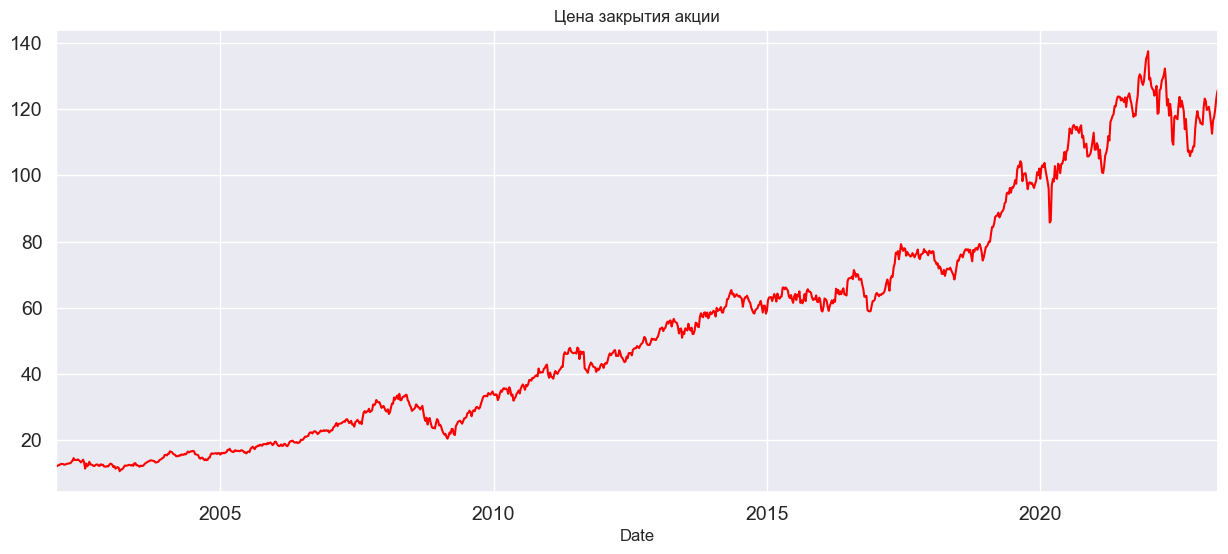

In [6]:
df.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="red")

По графику видно, что стоило вкладыватся в акции компании.  
Также ясно, что ряд не стационарен. В нём можно выразить трендовую зависимость.

**Тест Дикки-Фуллера на стационарность**  
Проверим на уровне значимости 0.05

In [7]:
dftest = adfuller(df.Close,autolag='AIC')

if dftest[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest[1])

p-value = 0.9927. The series is likely non-stationary.


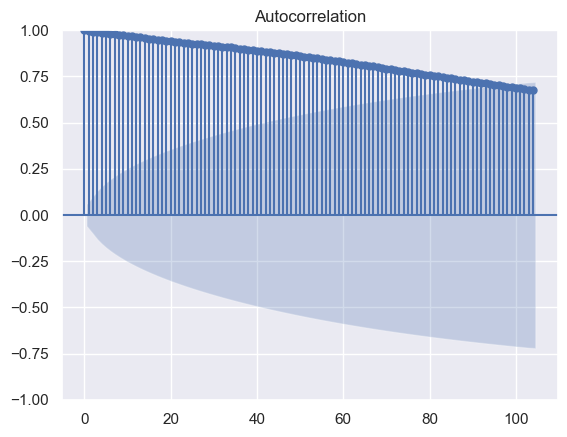

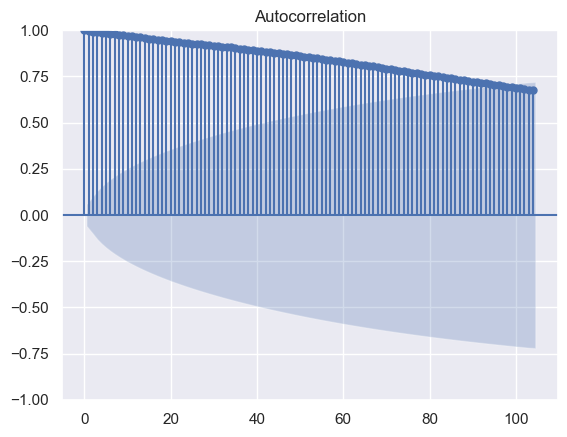

In [8]:
plot_acf(df.Close, lags=104)

Видна очень высокая зависимость лагов

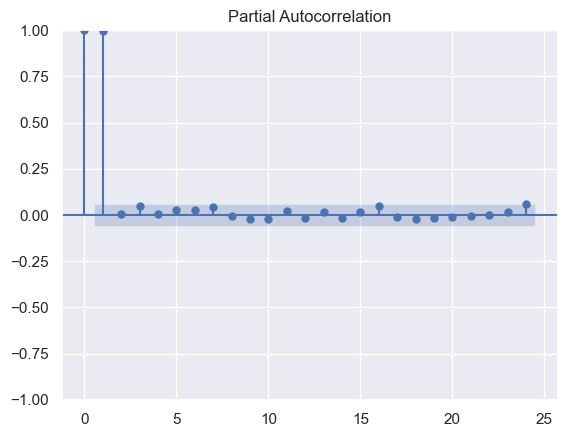

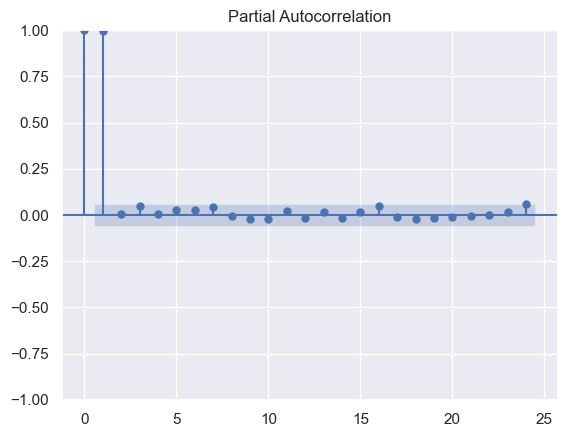

In [9]:
plot_pacf(df.Close, lags=24)

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели.  
Предлагается для начала избавится от трендовой зависимости

In [10]:
df["indexs"] = range(1, len(df)+1, 1)

In [11]:
from sklearn.linear_model import LinearRegression

X = np.array(df["indexs"]).reshape((-1, 1))
Y = np.array(df["Close"])

model = LinearRegression().fit(X,Y)
print('Y=', model.coef_[0], '*X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))

Y= 0.10365038221793772 *X + -3.5519061470129216
coefficient of determination: 0.9329182384007239


In [12]:
df["Close_t"] = df["Close"] - (df["indexs"] * model.coef_[0] + model.intercept_)
df

,Close,indexs,Close_t
Date,,,
2002-01-01 00:00:00-05:00,12.225895,1,15.674151
2002-01-08 00:00:00-05:00,12.115646,2,15.460252
2002-01-15 00:00:00-05:00,12.345325,3,15.586280
2002-01-22 00:00:00-05:00,12.414228,4,15.551533
2002-01-29 00:00:00-05:00,12.575006,5,15.608660
...,...,...,...
2023-03-14 00:00:00-04:00,117.559998,1107,6.370931
2023-03-21 00:00:00-04:00,119.849998,1108,8.557281
2023-03-28 00:00:00-04:00,123.000000,1109,11.603632


<AxesSubplot:title={'center':'Без тренда'}, xlabel='Date'>

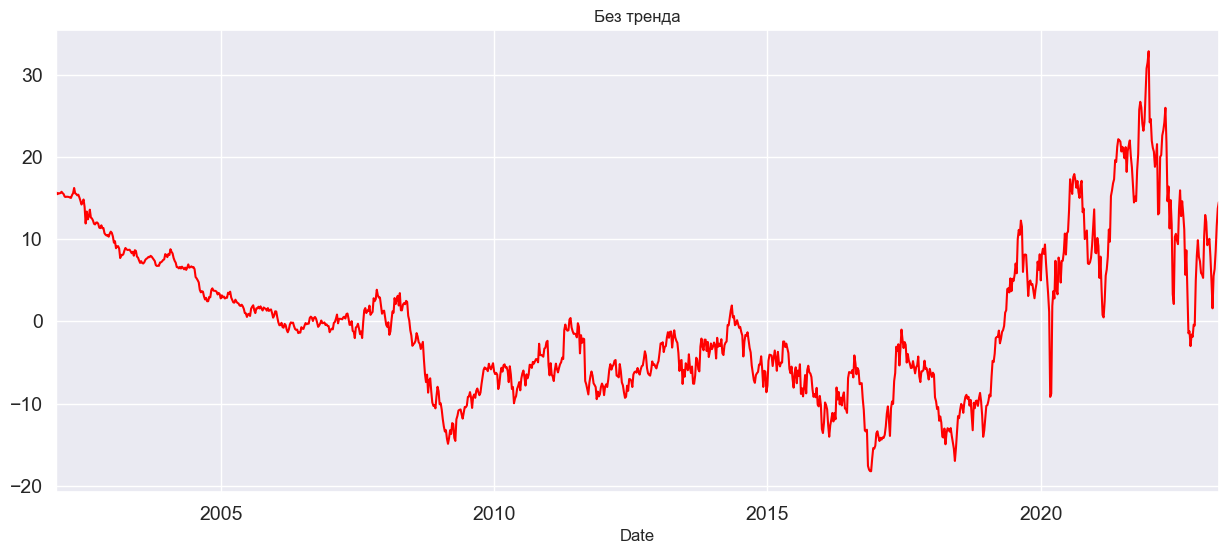

In [13]:
df.Close_t.plot( figsize=(15,6),title= 'Без тренда', fontsize=14, color="red")

In [14]:
dftest_t = adfuller(df.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])

p-value = 0.1467. The series is likely non-stationary.


Ряд всё ещё не стационарен, однако, значение p-value уменьшилось в разы. Добрый знак

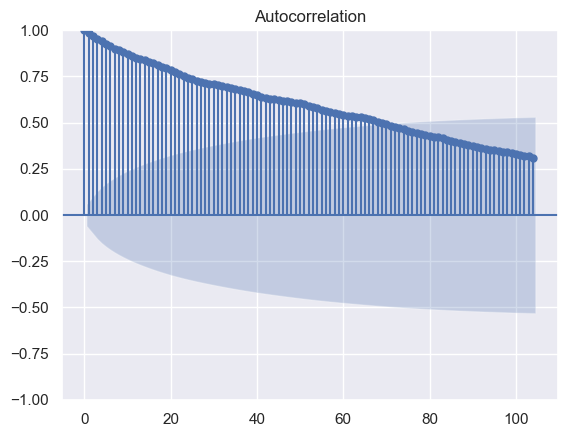

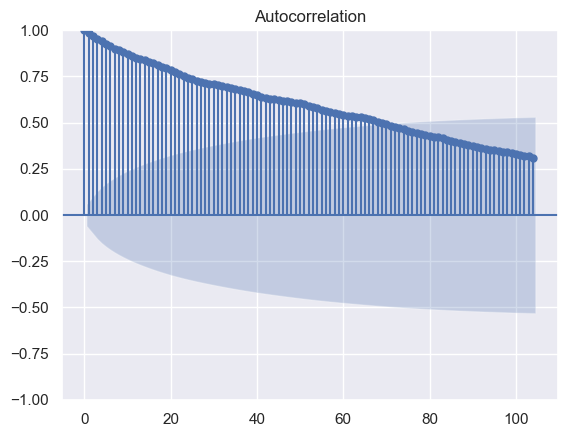

In [15]:
plot_acf(df.Close_t, lags=104)

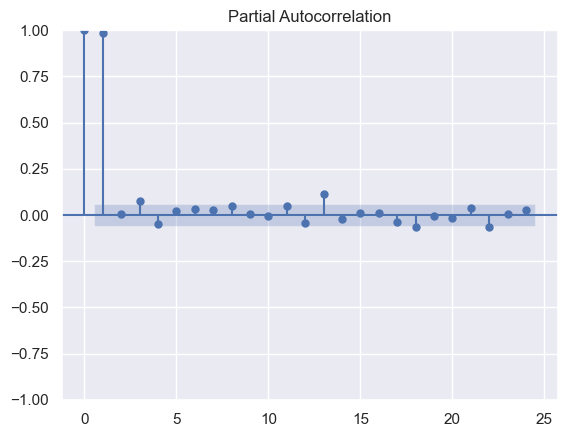

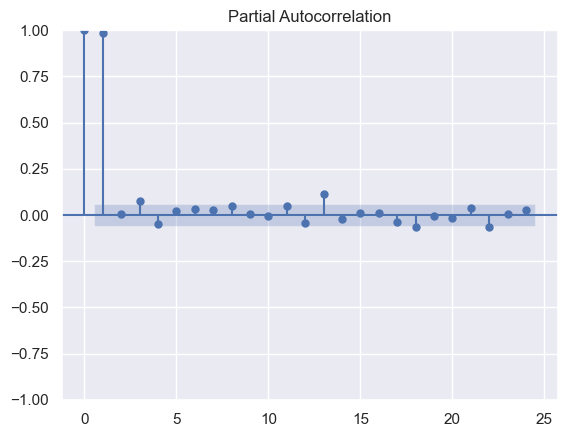

In [16]:
plot_pacf(df.Close_t, lags=24)

Нам удалось уменьшить зависимость цены акции от предыдущих значений, однако, оно всё ещё очень велико.

Разделим данные

In [17]:
from sklearn. model_selection import train_test_split

train, test = df[0:1000], df[1000:]
print(train.shape, test.shape)

(1000, 3) (111, 3)


In [19]:
p = range(0,3)
d = range(0,3)
q = range(0,15)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
print(best_params, best_MAE)

  0%|          | 0/135 [00:00<?, ?it/s]

(2, 1, 14) 0.7992933409708737


Таким образом на преобразованных данных можно построить модель ARIMA(2,1,14)

In [20]:
p = range(0,3)
d = range(0,3)
q = range(0,15)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
print(best_params, best_MAE)

  0%|          | 0/135 [00:00<?, ?it/s]

(2, 1, 14) 0.80356880668188


Таким образом на исзодных данных можно построить модель ARIMA(2,1,14). Она сложнее нежели модель без тренда, однако, даёт лучшие результаты

Проверим модель на тестовой выборке

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
model_test = sm.tsa.arima.ARIMA(test.Close, order = (2,1,14))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

print(mean_absolute_percentage_error(test.Close, preds))

2.5605949125261387


Ошибка увеличилась не сильно  
Построим прогноз

In [24]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

In [25]:
y = pd.Series(test.Close, index=test.index)
y

Date
2021-03-02 00:00:00-05:00    100.684418
2021-03-09 00:00:00-05:00    102.759216
2021-03-16 00:00:00-04:00    105.976082
2021-03-23 00:00:00-04:00    106.842171
2021-03-30 00:00:00-04:00    108.460121
                                ...    
2023-03-14 00:00:00-04:00    117.559998
2023-03-21 00:00:00-04:00    119.849998
2023-03-28 00:00:00-04:00    123.000000
2023-04-04 00:00:00-04:00    125.220001
2023-04-11 00:00:00-04:00    126.099998
Name: Close, Length: 111, dtype: float64

In [26]:
print(pred_ci)

                           lower Close  upper Close
2023-04-18 00:00:00-04:00   123.450101   133.139596
2023-04-25 00:00:00-04:00   120.361872   134.971875
2023-05-02 00:00:00-04:00   117.364850   135.855755
2023-05-09 00:00:00-04:00   116.057042   137.204071
2023-05-16 00:00:00-04:00   115.724072   139.618836
2023-05-23 00:00:00-04:00   118.250919   144.431435
2023-05-30 00:00:00-04:00   116.806892   144.284347
2023-06-06 00:00:00-04:00   115.321617   143.565410
2023-06-13 00:00:00-04:00   114.078657   143.167266
2023-06-20 00:00:00-04:00   111.692338   142.245353


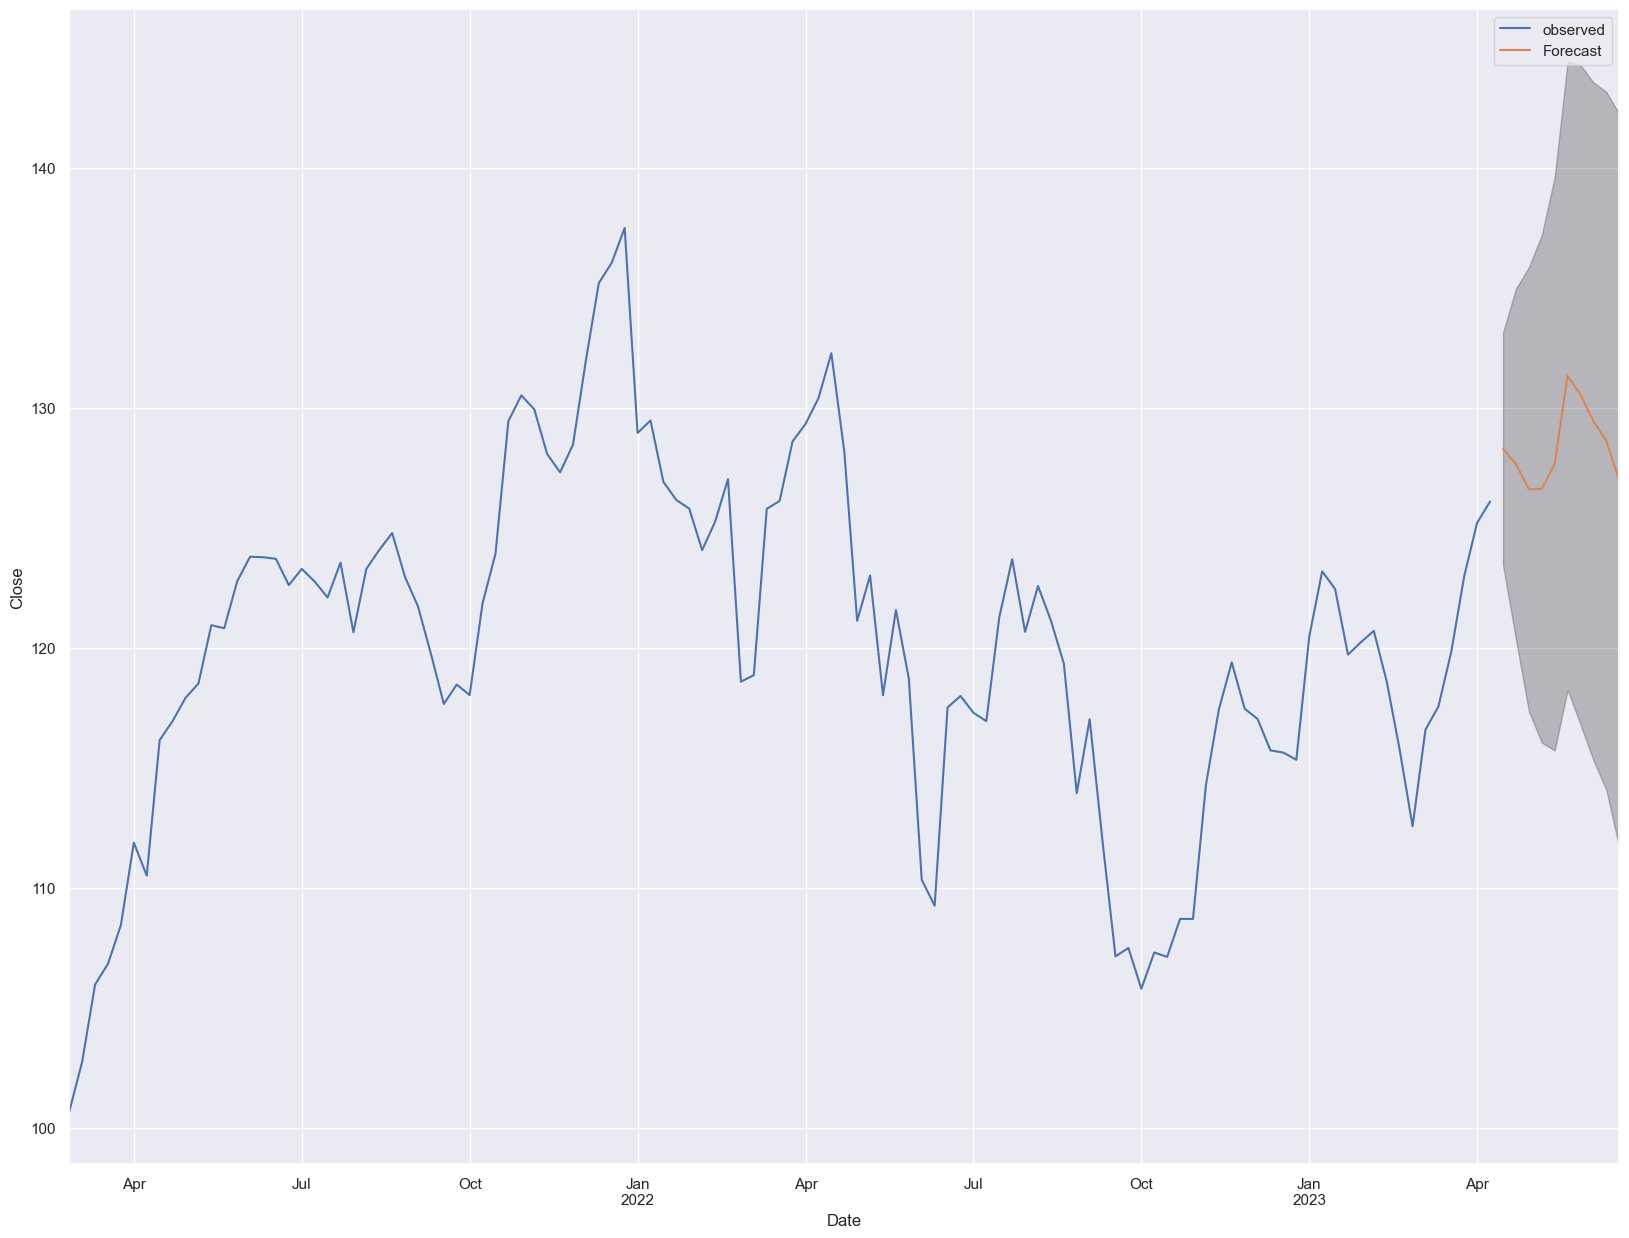

In [27]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()

Судя по графику, в дальнейшем цены на акции этой компании продолжат возрастать, а потом начнут снижаться

<AxesSubplot:title={'center':'Цена закрытия акции'}, xlabel='Date'>

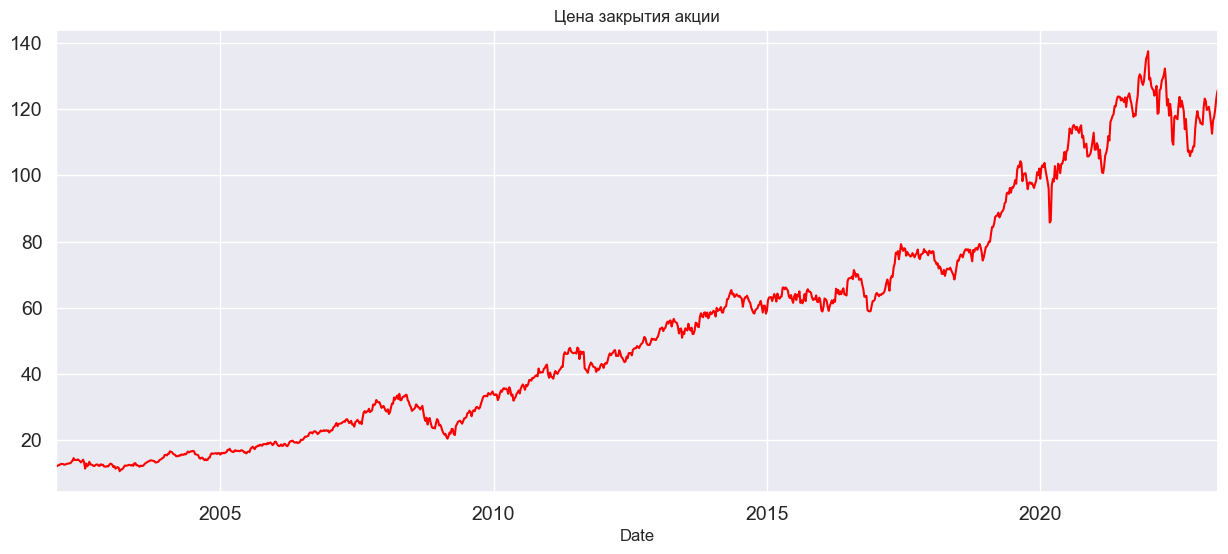

In [28]:
df.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="red")

Требуется разделить исходные данные на 3 блока  
Предлагается взять такие интервалы:  
1. Начало - середина 2008-2009 (примерный локальный максимум)  
2. середина 2008-2009 - 2017
3. 2017 - конец

In [29]:
df_1 = df.index < '2008-06-25 00:00:00-04:00'
df_1 = df.loc[df_1]
df_1

,Close,indexs,Close_t
Date,,,
2002-01-01 00:00:00-05:00,12.225895,1,15.674151
2002-01-08 00:00:00-05:00,12.115646,2,15.460252
2002-01-15 00:00:00-05:00,12.345325,3,15.586280
2002-01-22 00:00:00-05:00,12.414228,4,15.551533
2002-01-29 00:00:00-05:00,12.575006,5,15.608660
...,...,...,...
2008-05-27 00:00:00-04:00,33.660603,335,2.489631
2008-06-03 00:00:00-04:00,33.639030,336,2.364408
2008-06-10 00:00:00-04:00,32.055790,337,0.677517


In [30]:
df_2 = df.query("index >= '2008-06-25 00:00:00-04:00' & index < '2017-01-01 00:00:00-04:00'")
df_2

,Close,indexs,Close_t
Date,,,
2008-07-01 00:00:00-04:00,29.972233,340,-1.716991
2008-07-08 00:00:00-04:00,28.825935,341,-2.966939
2008-07-15 00:00:00-04:00,29.115881,342,-2.780644
2008-07-22 00:00:00-04:00,29.358629,343,-2.641546
2008-07-29 00:00:00-04:00,29.756464,344,-2.347361
...,...,...,...
2016-11-29 00:00:00-05:00,58.973255,779,-18.218486
2016-12-06 00:00:00-05:00,60.610920,780,-16.684472
2016-12-13 00:00:00-05:00,61.987255,781,-15.411787


In [31]:
df_3 = df.query("index > '2017-01-01 00:00:00-04:00'")
df_3

,Close,indexs,Close_t
Date,,,
2017-01-03 00:00:00-05:00,64.104012,784,-13.605982
2017-01-10 00:00:00-05:00,64.452461,785,-13.361183
2017-01-17 00:00:00-05:00,63.929790,786,-13.987504
2017-01-24 00:00:00-05:00,63.476833,787,-14.544111
2017-01-31 00:00:00-05:00,63.973347,788,-14.151248
...,...,...,...
2023-03-14 00:00:00-04:00,117.559998,1107,6.370931
2023-03-21 00:00:00-04:00,119.849998,1108,8.557281
2023-03-28 00:00:00-04:00,123.000000,1109,11.603632


In [32]:
train_1, test_1 = df_1[0:289], df_1[289:]
train_2, test_2 = df_2[0:377], df_2[377:]
train_3, test_3 = df_3[0:279], df_3[279:]

In [34]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_1.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
        
model_test = sm.tsa.arima.ARIMA(test_1.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'mape на train:',best_MAE, 'mape на test:', result_test.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 1 block: (4, 0, 8) mape на train: 0.307825728785068 mape на test: 0.7709350429161534


In [35]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_2.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
        
model_test = sm.tsa.arima.ARIMA(test_2.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 2 block:', best_params, 'mape на train:',best_MAE, 'mape на test:', result_test.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 2 block: (4, 0, 9) mape на train: 0.8355575981834499 mape на test: 1.015991705872466


In [36]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_3.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
        
model_test = sm.tsa.arima.ARIMA(test_3.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 3 block:', best_params, 'mape на train:',best_MAE, 'mape на test:', result_test.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 3 block: (3, 0, 5) mape на train: 1.57175792106171 mape на test: 2.2105176056885942


Лучшей моделью можно считать номер 1.